<a href="https://colab.research.google.com/github/straxFromIbr/Pics2LGate/blob/main/Pic2LGate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像から回路構造を抽出

In [ ]:
!wget 'https://raw.githubusercontent.com/straxFromIbr/Pics2LGate/main/image.jpg' &>/dev/null
!pip install sknw

In [66]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import io as skio
from skimage import draw
from skimage import transform
from skimage import filters
from skimage import morphology

import sknw
import networkx as nx


### 画像の読み込み
- ./image.jpgを読み込む
- そのままだと大きすぎる(998, 2167, 3)ので、1/5に縮小
- 加えて枠も表示([Ymin, Ymax, Xmin, Xmax]の順番)


In [67]:
def draw_bbox(image, bbox, color=0):
    """
    * 枠線描画関数
    """
    with_boxes = np.copy(image)
    r = [bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]]
    c = [bbox[3], bbox[3], bbox[2], bbox[2], bbox[3]]
    rr, cc = draw.polygon_perimeter(r, c, shape=image.shape)
    with_boxes[rr, cc] = color
    return with_boxes


def draw_rect(image, bbox, color=0):
    """
    * 枠線の中をcolorで塗りつぶす関数
    """
    with_boxes = np.copy(image)
    r = [bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]]
    c = [bbox[3], bbox[3], bbox[2], bbox[2], bbox[3]]
    rr, cc = draw.polygon(r, c, shape=image.shape)
    with_boxes[rr, cc] = color
    return with_boxes


In [68]:
# * 読み込み & 縮小
org_image = skio.imread("./image.jpg", as_gray=True)
scale = 0.1
org_image = transform.rescale(org_image, scale)

# * 枠線の座標(Yoloとかで求める)
BBOX_AND1 = np.array((150, 500, 700, 1100)) * scale
BBOX_OR1 = np.array((650, 950, 650, 1100)) * scale
BBOX_OR2 = np.array((250, 550, 1300, 1800)) * scale

image_with_bbox = draw_bbox(org_image, BBOX_AND1)
image_with_bbox = draw_bbox(image_with_bbox, BBOX_OR1)
image_with_bbox = draw_bbox(image_with_bbox, BBOX_OR2)



In [69]:
# * 二値化
thr = filters.threshold_otsu(org_image)
bin_image_org = org_image < thr

# * 回路素子の部分を塗りつぶす
bin_image = draw_rect(bin_image_org, BBOX_AND1, color=1)
bin_image = draw_rect(bin_image, BBOX_OR1, color=1)
bin_image = draw_rect(bin_image, BBOX_OR2, color=1)

# * 細線化
skl_image = morphology.skeletonize(bin_image)


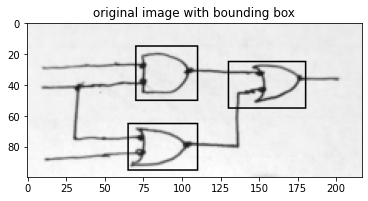

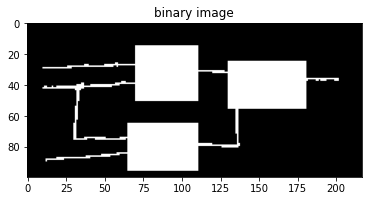

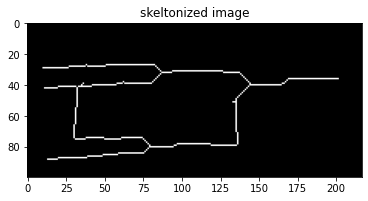

In [70]:
plt.title("original image with bounding box")
plt.imshow(image_with_bbox, cmap="gray")
plt.show()
plt.title("binary image")
plt.imshow(bin_image, cmap="gray")
plt.show()
plt.title("skeltonized image")
plt.imshow(skl_image, cmap="gray")
plt.show()


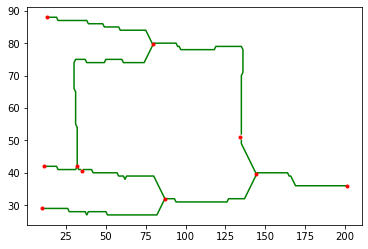

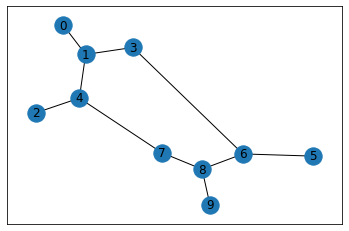

In [72]:
# 細線化画像からグラフ構築
graph = sknw.build_sknw(skl_image)

# もとの頂点座標を考慮してグラフを描画
for s, e in graph.edges():
    ps = graph[s][e]["pts"]
    plt.plot(ps[:, 1], ps[:, 0], "green")
nodes = graph.nodes()
ps = np.array([nodes[i]["o"] for i in nodes])
plt.plot(ps[:, 1], ps[:, 0], "r.")
plt.show()

# グラフの繋がり方だけ描画
nx.draw_networkx(graph)
plt.show()
